In [18]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from preprocess import extract_images
from dataset import get_full_list, ChineseCharacterDataset
from model import VAE, vae_loss, ConvVAE
from utils import visualize_images, show_images

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading and Preprocessing:

In [20]:
# Set the directory and load the dataset
image_dir = './dataset'
full_data_list = get_full_list(image_dir)

train_size = int(0.1 * len(full_data_list))
train_data_set = ChineseCharacterDataset(full_data_list[:train_size])

print("Training Set Size:", len(train_data_set))

# Create data loaders
train_loader = DataLoader(train_data_set, batch_size=32, shuffle=True)

Training Set Size: 24357


### Training:

In [21]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [22]:
# Train
def train(model, train_data_set, input_dim, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_data_set):
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(data)
            loss = vae_loss(reconstructed_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_data_set.dataset)}')
    print(f'Final Loss: {train_loss/len(train_data_set.dataset)}')

In [23]:
input_dim = 64 * 64
z_dim = 50
learning_rate = 1e-4

num_epochs = 100

model = ConvVAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train(model, train_loader, input_dim, optimizer, scheduler, num_epochs) 

Epoch 1, Loss: 1634.9111224883695
Epoch 2, Loss: 1309.9753806977974
Epoch 3, Loss: 1217.6924592712055
Epoch 4, Loss: 1191.7174577797193
Epoch 5, Loss: 1178.409080215005
Epoch 6, Loss: 1168.8459009273195
Epoch 7, Loss: 1161.50725365382
Epoch 8, Loss: 1155.3986755964982
Epoch 9, Loss: 1150.1444311961461
Epoch 10, Loss: 1145.6647886772796
Epoch 11, Loss: 1140.533854266901
Epoch 12, Loss: 1138.575695361254
Epoch 13, Loss: 1136.5679280067716
Epoch 14, Loss: 1134.6464126473525
Epoch 15, Loss: 1133.03637395612
Epoch 16, Loss: 1131.4700411577974
Epoch 17, Loss: 1129.8759037723692
Epoch 18, Loss: 1128.578603438244
Epoch 19, Loss: 1127.036968686171
Epoch 20, Loss: 1125.811712699859
Epoch 21, Loss: 1123.6673387174376
Epoch 22, Loss: 1122.9197171565156
Epoch 23, Loss: 1122.388967145129
Epoch 24, Loss: 1121.615116780148
Epoch 25, Loss: 1121.0507278852717
Epoch 26, Loss: 1120.4455126277546
Epoch 27, Loss: 1120.0085009691452
Epoch 28, Loss: 1119.2951390225346
Epoch 29, Loss: 1118.7872917813347
Epoch 

### Generating Images:

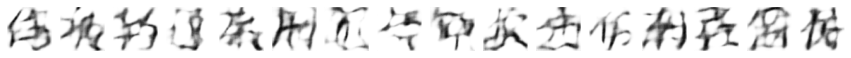

In [24]:
# Generating images
num_images = 10  # Number of images you want to generate
generated_images = model.generate(num_images)

for i in range(num_images):
    img = generated_images[i].cpu().detach().numpy().reshape(64, 64)
    plt.imshow(img, cmap='gray')
    plt.show()